In [1]:
import numpy as np
import pandas as pd

from dataclasses import dataclass
from typing import Tuple, Dict

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import kagglehub
import yfinance as yf
from openai import OpenAI
import os


In [2]:
@dataclass
class PaperConfig:
    start_date_train: str = "1998-01-01"
    end_date_train: str = "2015-12-31"
    start_date_test: str = "2016-01-01"
    end_date_test: str = "2019-12-31"

    pca_components: int = 4          # best model in Table II
    hidden_size: int = 32
    dropout: float = 0.3
    batch_size: int = 64
    lr: float = 1e-3
    epochs: int = 500

    # For reproducibility
    seed: int = 42

def set_seed(seed: int = 42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

cfg = PaperConfig()
set_seed(cfg.seed)


In [3]:
def load_spy_data() -> pd.DataFrame:
    """
    Return a DataFrame with index = Date, columns = ['open', 'close', 'volume'].
    """
    # TODO: replace with your actual loading logic
    df = yf.download("^GSPC", start="1998-01-01", end="2021-12-31")
    df = df.rename(columns=str.lower)[['open', 'close', 'volume']]
    df.index = df.index.tz_localize(None)
    return df
    raise NotImplementedError

def load_dxy_data() -> pd.DataFrame:
    dxy_raw = yf.download("DX-Y.NYB", start="1998-01-01", end="2021-12-31", auto_adjust=False)
    df = dxy_raw.rename(columns=str.lower)[['open', 'close', 'volume']]
    df.index = df.index.tz_localize(None)
    return df.rename(columns={
        'open': 'dxy_open',
        'close': 'dxy_close',
        'volume': 'dxy_volume',
    })


def load_yield_data() -> pd.DataFrame:
    """
    Download 3M and 10Y yields from Yahoo and return a flat DataFrame:
    index = Date, columns = ['yield_3m', 'yield_10y'].
    """
    # ^IRX = 13-week T-bill (proxy for 3M), ^TNX = 10Y treasury
    tickers = {"^IRX": "yield_3m", "^TNX": "yield_10y"}

    raw = yf.download(list(tickers.keys()),
                      start="1998-01-01",
                      end="2021-12-31",
                      auto_adjust=False)

    # raw.columns: MultiIndex (field, ticker). We want Close prices.
    close = raw["Close"].copy()        # columns: ['^IRX','^TNX']

    close.columns = [tickers[c] for c in close.columns]
    close.index = close.index.tz_localize(None)

    return close      # columns: ['yield_3m', 'yield_10y']




In [4]:
def load_wsj_headlines() -> pd.DataFrame:
    df_headlines = pd.read_csv(r"wsj_headlines.csv")
    df_headlines = df_headlines.rename(columns={"Date": "date", "Headline": "headline", "Category": "category"})
    df_headlines.index = pd.to_datetime(df_headlines["date"])
    df_headlines = df_headlines[["date","headline", "category"]]
    return df_headlines
    raise NotImplementedError


In [5]:
# Crear el cliente una sola vez (usa OPENAI_API_KEY del entorno)
client = OpenAI()

In [6]:
def embed_headline(text: str) -> np.ndarray:
    """
    Embebe un titular (o cualquier texto corto) usando text-embedding-3-small
    y devuelve un vector np.ndarray de float32.
    """
    resp = client.embeddings.create(
        model="text-embedding-3-small",
        input=text
    )
    # resp.data[0].embedding es la lista de floats que devuelve la API
    return np.array(resp.data[0].embedding, dtype=np.float32)


In [7]:
def build_headline_embeddings(headlines_df: pd.DataFrame) -> pd.DataFrame:
    """
    headlines_df: columns ['date', 'headline']
    Returns DataFrame indexed by date with a column 'embedding' that holds np.array(1536,)
    and also expanded numeric columns if desired.
    """
    rows = []
    for _, row in headlines_df.iterrows():
        emb = embed_headline(row["headline"])
        rows.append({
            "date": row["date"],
            "embedding": emb
        })
    emb_df = pd.DataFrame(rows)
    emb_df["date"] = pd.to_datetime(emb_df["date"]).dt.normalize()
    return emb_df


In [8]:
def select_one_headline_per_day(emb_df: pd.DataFrame) -> pd.DataFrame:
    """
    emb_df: ['date', 'embedding']
    Returns DataFrame indexed by date, exactly one embedding per date.
    """
    # Randomly choose one row per date
    emb_df = emb_df.sample(frac=1.0, random_state=cfg.seed)  # shuffle
    one_per_day = emb_df.drop_duplicates(subset="date", keep="first")
    one_per_day = one_per_day.set_index("date").sort_index()
    return one_per_day


In [9]:
def fit_pca_on_train(embeddings: pd.DataFrame, cfg: PaperConfig) -> Tuple[PCA, pd.DataFrame]:
    """
    embeddings: DataFrame indexed by date, column 'embedding' (np.array)
    Returns fitted PCA and DataFrame with columns ['pca_1', ..., 'pca_k'].
    """
    # Convert list/array column into 2D matrix
    X = np.stack(embeddings["embedding"].values)  # shape (n_days, 1536)

    pca = PCA(n_components=cfg.pca_components, random_state=cfg.seed)
    X_pca = pca.fit_transform(X)

    cols = [f"headline_pca_{i+1}" for i in range(cfg.pca_components)]
    pca_df = pd.DataFrame(X_pca, index=embeddings.index, columns=cols)
    return pca, pca_df


In [10]:
def apply_pca(embeddings: pd.DataFrame, pca: PCA, cfg: PaperConfig) -> pd.DataFrame:
    X = np.stack(embeddings["embedding"].values)
    X_pca = pca.transform(X)
    cols = [f"headline_pca_{i+1}" for i in range(cfg.pca_components)]
    pca_df = pd.DataFrame(X_pca, index=embeddings.index, columns=cols)
    return pca_df

In [11]:
def build_merged_dataset(cfg: PaperConfig) -> pd.DataFrame:
    spy = load_spy_data()
    dxy = load_dxy_data()
    yld = load_yield_data()

    spy.index = pd.to_datetime(spy.index).tz_localize(None)
    dxy.index = pd.to_datetime(dxy.index).tz_localize(None)
    yld.index = pd.to_datetime(yld.index).tz_localize(None)

    spy = spy.sort_index()
    spy["log_ret_next"] = np.log(spy["close"].shift(-1) / spy["close"])

    df = spy[["open", "close", "volume", "log_ret_next"]].copy()
    df = df.join(dxy[["dxy_open"]], how="left")
    df = df.join(yld[["yield_3m", "yield_10y"]], how="left")



    # 3) Headline embeddings (assume precomputed)
    # Suppose you already have a DataFrame 'headline_embs'
    # indexed by date with column 'embedding'.
    # Here we just show the flow.
    raise NotImplementedError("You need to prepare headline_embs DataFrame")


In [12]:
def add_headline_pca_features(df: pd.DataFrame,
                              headline_embs: pd.DataFrame,
                              cfg: PaperConfig) -> Tuple[pd.DataFrame, PCA]:
    """
    df: price+macro DataFrame indexed by date
    headline_embs: DataFrame indexed by date with column 'embedding' (np.array)
    """
    # Align headline embeddings with df index
    emb_aligned = headline_embs.reindex(df.index).dropna(subset=["embedding"])

    # Fit PCA on training period only
    train_mask = (emb_aligned.index >= cfg.start_date_train) & (emb_aligned.index <= cfg.end_date_train)
    emb_train = emb_aligned[train_mask]

    pca, _ = fit_pca_on_train(emb_train, cfg)

    # Transform full (train + test) embeddings
    pca_full = apply_pca(emb_aligned, pca, cfg)   # index = dates where we have embeddings

    # Safely align PCA features to df's index and assign column by column
    pca_full_aligned = pca_full.reindex(df.index)

    for col in pca_full_aligned.columns:
        df[col] = pca_full_aligned[col]

    return df, pca


In [13]:
def flatten_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    If df.columns is a MultiIndex like ('open', '^gspc'),
    flatten it to just 'open' (first element of the tuple).
    """
    if isinstance(df.columns, pd.MultiIndex):
        df = df.copy()
        df.columns = [c[0] if isinstance(c, tuple) else c for c in df.columns]
    return df


In [14]:
def finalize_dataset(df: pd.DataFrame, cfg: PaperConfig) -> Tuple[pd.DataFrame, pd.DataFrame, StandardScaler]:
    """
    Split into train/test, handle missing data, and scale features.
    """

    # --- FLATTEN COLUMNS ---
    df = flatten_columns(df)

    # --- Debug: show columns & check target ---
    print("DEBUG finalize_dataset | columns:", list(df.columns)[:20])
    print("DEBUG finalize_dataset | 'log_ret_next' present?", "log_ret_next" in df.columns)

    # Ensure target column exists
    if "log_ret_next" not in df.columns:
        if "close" not in df.columns:
            raise ValueError(
                "finalize_dataset: df has no 'log_ret_next' and no 'close' to compute it from. "
                f"Columns are: {list(df.columns)}"
            )
        df = df.sort_index()
        df["log_ret_next"] = np.log(df["close"].shift(-1) / df["close"])
        print("DEBUG finalize_dataset | created 'log_ret_next' from 'close'.")

    # Drop rows without target
    df = df.dropna(subset=["log_ret_next"])

    # Define base feature columns
    feature_cols = [
        "open", "close", "volume",
        "dxy_open", "yield_3m", "yield_10y",
    ]

    # Add PCA columns if present
    pca_cols = [c for c in df.columns
                if isinstance(c, str) and c.startswith("headline_pca_")]
    feature_cols += pca_cols

    # Drop rows with missing features (or you could impute)
    df = df.dropna(subset=feature_cols)

    # Train/test split by date
    train_mask = (df.index >= cfg.start_date_train) & (df.index <= cfg.end_date_train)
    test_mask  = (df.index >= cfg.start_date_test)  & (df.index <= cfg.end_date_test)

    train_df = df[train_mask].copy()
    test_df  = df[test_mask].copy()

    X_train = train_df[feature_cols].values
    y_train = train_df["log_ret_next"].values

    X_test  = test_df[feature_cols].values
    y_test  = test_df["log_ret_next"].values

    # Scale features on train only
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    # Store scaled arrays back into the DataFrames
    for i, col in enumerate(feature_cols):
        train_df[col] = X_train_scaled[:, i]
        test_df[col]  = X_test_scaled[:, i]

    return train_df, test_df, scaler


In [15]:
def finalize_dataset_price_target(df: pd.DataFrame, cfg: PaperConfig):
    """
    Version closer to the paper: predict next-day *normalized close* instead of log-return.

    Returns:
        train_df, test_df, scaler, feature_cols
    """
    df = flatten_columns(df)
    df = df.sort_index()

    # --- 1) Compute normalized close using TRAIN-period stats ---
    # Use the *full* df index to find the training window for normalization
    train_window_mask = (df.index >= cfg.start_date_train) & (df.index <= cfg.end_date_train)
    close_train = df.loc[train_window_mask, "close"]

    close_min, close_max = close_train.min(), close_train.max()
    df["close_norm"] = (df["close"] - close_min) / (close_max - close_min)

    # Target: next-day normalized close
    df["close_norm_next"] = df["close_norm"].shift(-1)

    # --- 2) Define feature columns ---
    feature_cols = [
        "close_norm",   # key feature emphasized in the paper
        "open",
        "volume",
        "dxy_open",
        "yield_3m",
        "yield_10y",
    ]

    # Add PCA news features if present
    pca_cols = [c for c in df.columns
                if isinstance(c, str) and c.startswith("headline_pca_")]
    feature_cols += pca_cols

    # --- 3) Drop rows missing target or features ---
    df = df.dropna(subset=["close_norm_next"])
    df = df.dropna(subset=feature_cols)

    # --- 4) Recompute train/test masks AFTER drops (important!) ---
    train_mask = (df.index >= cfg.start_date_train) & (df.index <= cfg.end_date_train)
    test_mask  = (df.index >= cfg.start_date_test)  & (df.index <= cfg.end_date_test)

    train_df = df.loc[train_mask].copy()
    test_df  = df.loc[test_mask].copy()

    # --- 5) Scale features on train only ---
    X_train = train_df[feature_cols].values
    X_test  = test_df[feature_cols].values

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    for i, col in enumerate(feature_cols):
        train_df[col] = X_train_scaled[:, i]
        test_df[col]  = X_test_scaled[:, i]

    return train_df, test_df, scaler, feature_cols


In [16]:
class TimeIndependentDataset(Dataset):
    def __init__(self, df: pd.DataFrame, feature_cols: list, target_col: str = "log_ret_next"):
        self.X = df[feature_cols].values.astype(np.float32)
        self.y = df[target_col].values.astype(np.float32).reshape(-1, 1)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [17]:
class FFNN(nn.Module):
    def __init__(self, input_dim: int, hidden_size: int = 32, dropout: float = 0.3):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)
        self.fc2 = nn.Linear(hidden_size, 1)

        # Xavier init
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [18]:
def smape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Symmetric Mean Absolute Percentage Error in percent.
    """
    denom = (np.abs(y_true) + np.abs(y_pred))
    # avoid division by zero
    denom = np.where(denom == 0, 1e-8, denom)
    return 100.0 * np.mean(np.abs(y_true - y_pred) / denom * 2.0)


In [19]:
def train_model(model: nn.Module,
                train_loader: DataLoader,
                val_loader: DataLoader,
                cfg: PaperConfig,
                device: str = "cpu") -> Dict[str, float]:
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)

    model.to(device)

    for epoch in range(cfg.epochs):
        model.train()
        train_losses = []

        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        # Optional: simple validation loss tracking
        if (epoch + 1) % 50 == 0 or epoch == 0:
            model.eval()
            val_losses = []
            with torch.no_grad():
                for X_val, y_val in val_loader:
                    X_val = X_val.to(device)
                    y_val = y_val.to(device)
                    preds = model(X_val)
                    loss = criterion(preds, y_val)
                    val_losses.append(loss.item())

            print(f"Epoch {epoch+1}/{cfg.epochs} "
                  f"Train MSE: {np.mean(train_losses):.6f} "
                  f"Val MSE: {np.mean(val_losses):.6f}")

    # Return model; metrics computed separately
    return {}


In [20]:
def evaluate_model(model: nn.Module,
                   df: pd.DataFrame,
                   feature_cols: list,
                   target_col: str = "log_ret_next",
                   device: str = "cpu") -> Dict[str, float]:
    model.eval()
    X = df[feature_cols].values.astype(np.float32)
    y_true = df[target_col].values.astype(np.float32)

    with torch.no_grad():
        X_tensor = torch.from_numpy(X).to(device)
        y_pred = model(X_tensor).cpu().numpy().flatten()

    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    s = smape(y_true, y_pred)

    return {"MSE": mse, "R2": r2, "SMAPE": s}, y_true, y_pred


In [22]:
df_headlines = load_wsj_headlines()
emb_df = build_headline_embeddings(df_headlines[["date", "headline"]])
one_per_day = select_one_headline_per_day(emb_df)
headline_embs = one_per_day  




In [29]:
def run_best_paper_model_price_target(cfg: PaperConfig,
                                      headline_embs: pd.DataFrame) -> None:
    """
    Approximate replication of the paper's best model, but with
    normalized price target instead of raw log-return.
    """
    # 1) Base SPX + macro data
    spy = load_spy_data()
    dxy = load_dxy_data()
    yld = load_yield_data()

    for frame in (spy, dxy, yld):
        if isinstance(frame.index, pd.MultiIndex):
            frame.index = frame.index.get_level_values(0)
        frame.index = pd.to_datetime(frame.index).tz_localize(None)

    spy = spy.sort_index()

    # Base df (no log_ret_next target here)
    df = spy[["open", "close", "volume"]].copy()
    df["dxy_open"]  = dxy["dxy_open"].reindex(df.index)
    df["yield_3m"]  = yld["yield_3m"].reindex(df.index)
    df["yield_10y"] = yld["yield_10y"].reindex(df.index)

    # 2) Add PCA headline features
    if headline_embs is not None:
        df, pca = add_headline_pca_features(df, headline_embs, cfg)

    # 3) Build normalized-price dataset
    train_df, test_df, scaler, feature_cols = finalize_dataset_price_target(df, cfg)

    # 4) Inner train/val split (time-based)
    train_mask_inner = train_df.index < "2014-01-01"
    val_mask_inner   = train_df.index >= "2014-01-01"

    train_inner = train_df[train_mask_inner]
    val_inner   = train_df[val_mask_inner]

    train_dataset = TimeIndependentDataset(train_inner, feature_cols, target_col="close_norm_next")
    val_dataset   = TimeIndependentDataset(val_inner, feature_cols, target_col="close_norm_next")

    train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=cfg.batch_size, shuffle=False)

    # 5) Model
    input_dim = len(feature_cols)
    model = FFNN(input_dim=input_dim,
                 hidden_size=cfg.hidden_size,
                 dropout=cfg.dropout)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # 6) Train
    train_model(model, train_loader, val_loader, cfg, device=device)

    # 7) Evaluate on normalized-price target
    train_metrics, _, _ = evaluate_model(
        model, train_df, feature_cols, target_col="close_norm_next", device=device
    )
    test_metrics, y_test, y_pred = evaluate_model(
        model, test_df, feature_cols, target_col="close_norm_next", device=device
    )

    print("Train metrics (normalized price):", train_metrics)
    print("Test  metrics (normalized price):", test_metrics)

    # 8) Plot normalized price true vs predicted
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 4))
    plt.plot(test_df.index, y_test, label="True norm. close", alpha=0.7)
    plt.plot(test_df.index, y_pred, label="Pred norm. close", alpha=0.7)
    plt.title("Next-day normalized close: true vs predicted (test set)")
    plt.xlabel("Date")
    plt.ylabel("Normalized price")
    plt.legend()
    plt.tight_layout()
    plt.show()
        # 9) Denormalize predictions (REAL units) + metrics + plots
    # We need the same close_min/close_max used for normalization: computed on TRAIN window only
    # The raw close series is in df["close"] and train_df has the training dates (cfg range).
    train_mask = (df.index >= cfg.start_date_train) & (df.index <= cfg.end_date_train)
    close_min = float(df.loc[train_mask, "close"].min())
    close_max = float(df.loc[train_mask, "close"].max())
    scale = close_max - close_min

    # Inverse min-max transform
    y_test_real = y_test * scale + close_min
    y_pred_real = y_pred * scale + close_min

    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

    # Metrics in normalized space (should match what you printed, just recalculated)
    mse_norm = mean_squared_error(y_test, y_pred)
    r2_norm  = r2_score(y_test, y_pred)

    # Metrics in real space (MSE changes units, R2 should be ~the same)
    mse_real = mean_squared_error(y_test_real, y_pred_real)
    r2_real  = r2_score(y_test_real, y_pred_real)
    rmse_real = mse_real ** 0.5
    mae_real  = mean_absolute_error(y_test_real, y_pred_real)

    print("\n--- Denormalization info ---")
    print(f"close_min(train)={close_min:.6f} close_max(train)={close_max:.6f} scale={scale:.6f}")

    print("\nMetrics (recomputed) - NORMALIZED target:")
    print({"MSE": mse_norm, "R2": r2_norm})

    print("\nMetrics - REAL close units:")
    print({"MSE": mse_real, "RMSE": rmse_real, "MAE": mae_real, "R2": r2_real})

    # Plot real close
    plt.figure(figsize=(12, 4))
    plt.plot(test_df.index, y_test_real, label="True close", alpha=0.7)
    plt.plot(test_df.index, y_pred_real, label="Pred close", alpha=0.7)
    plt.title("Next-day close (REAL units): true vs predicted (test set)")
    plt.xlabel("Date")
    plt.ylabel("Close")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot error in points (super useful to judge "too big")
    plt.figure(figsize=(12, 3))
    plt.plot(test_df.index, (y_pred_real - y_test_real), label="Error (Pred - True)", alpha=0.8)
    plt.axhline(0.0, linewidth=1)
    plt.title("Prediction error in REAL units (points)")
    plt.xlabel("Date")
    plt.ylabel("Points")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
        # 10) Returns: simple return and log-return (true vs predicted)
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

    close_t = test_df["close"].values.astype(float)   # precio real en t
    eps = 1e-12

    # --- Simple returns: (P_{t+1}/P_t) - 1 ---
    r_true_simple = (y_test_real / (close_t + eps)) - 1.0
    r_pred_simple = (y_pred_real / (close_t + eps)) - 1.0

    mse_s = mean_squared_error(r_true_simple, r_pred_simple)
    r2_s  = r2_score(r_true_simple, r_pred_simple)
    rmse_s = np.sqrt(mse_s)
    mae_s  = mean_absolute_error(r_true_simple, r_pred_simple)

    print("\nMetrics - SIMPLE returns:")
    print({"MSE": mse_s, "RMSE": rmse_s, "MAE": mae_s, "R2": r2_s})

    plt.figure(figsize=(12, 4))
    plt.plot(test_df.index, r_true_simple, label="True simple return", alpha=0.7)
    plt.plot(test_df.index, r_pred_simple, label="Pred simple return", alpha=0.7)
    plt.title("Next-day SIMPLE return: true vs predicted (test set)")
    plt.xlabel("Date")
    plt.ylabel("Return")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 3))
    plt.plot(test_df.index, (r_pred_simple - r_true_simple), label="Error (Pred - True)", alpha=0.8)
    plt.axhline(0.0, linewidth=1)
    plt.title("SIMPLE return error (test set)")
    plt.xlabel("Date")
    plt.ylabel("Return error")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Log returns: log(P_{t+1}/P_t) ---
    r_true_log = np.log((y_test_real + eps) / (close_t + eps))
    r_pred_log = np.log((y_pred_real + eps) / (close_t + eps))

    mse_l = mean_squared_error(r_true_log, r_pred_log)
    r2_l  = r2_score(r_true_log, r_pred_log)
    rmse_l = np.sqrt(mse_l)
    mae_l  = mean_absolute_error(r_true_log, r_pred_log)

    print("\nMetrics - LOG returns:")
    print({"MSE": mse_l, "RMSE": rmse_l, "MAE": mae_l, "R2": r2_l})

    plt.figure(figsize=(12, 4))
    plt.plot(test_df.index, r_true_log, label="True log return", alpha=0.7)
    plt.plot(test_df.index, r_pred_log, label="Pred log return", alpha=0.7)
    plt.title("Next-day LOG return: true vs predicted (test set)")
    plt.xlabel("Date")
    plt.ylabel("Log return")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 3))
    plt.plot(test_df.index, (r_pred_log - r_true_log), label="Error (Pred - True)", alpha=0.8)
    plt.axhline(0.0, linewidth=1)
    plt.title("LOG return error (test set)")
    plt.xlabel("Date")
    plt.ylabel("Log return error")
    plt.legend()
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_97729/4064750746.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("^GSPC", start="1998-01-01", end="2021-12-31")
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  2 of 2 completed


Epoch 1/500 Train MSE: 0.499840 Val MSE: 0.230306
Epoch 50/500 Train MSE: 0.001840 Val MSE: 0.002524
Epoch 100/500 Train MSE: 0.000951 Val MSE: 0.002542
Epoch 150/500 Train MSE: 0.000737 Val MSE: 0.000680
Epoch 200/500 Train MSE: 0.000718 Val MSE: 0.000253
Epoch 250/500 Train MSE: 0.000699 Val MSE: 0.000196
Epoch 300/500 Train MSE: 0.000648 Val MSE: 0.000229
Epoch 350/500 Train MSE: 0.000659 Val MSE: 0.000227
Epoch 400/500 Train MSE: 0.000654 Val MSE: 0.000293
Epoch 450/500 Train MSE: 0.000631 Val MSE: 0.000531
Epoch 500/500 Train MSE: 0.000694 Val MSE: 0.000317
Train metrics (normalized price): {'MSE': np.float32(0.00017560922), 'R2': 0.9961739778518677, 'SMAPE': np.float32(3.3767483)}
Test  metrics (normalized price): {'MSE': np.float32(0.00083755964), 'R2': 0.9840511679649353, 'SMAPE': np.float32(2.0095258)}


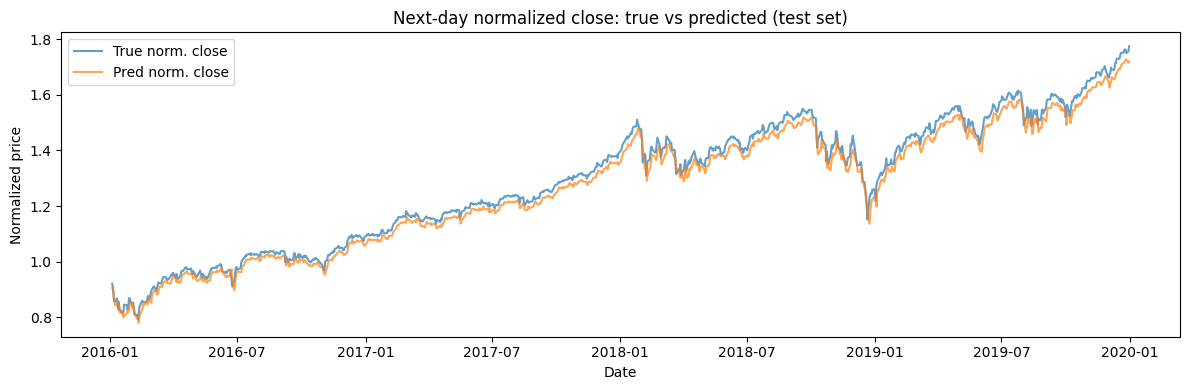

/tmp/ipykernel_97729/4035790290.py:82: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  close_min = float(df.loc[train_mask, "close"].min())
/tmp/ipykernel_97729/4035790290.py:83: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  close_max = float(df.loc[train_mask, "close"].max())



--- Denormalization info ---
close_min(train)=676.530029 close_max(train)=2130.820068 scale=1454.290039

Metrics (recomputed) - NORMALIZED target:
{'MSE': np.float32(0.00083755964), 'R2': 0.9840511679649353}

Metrics - REAL close units:
{'MSE': np.float32(1771.4052), 'RMSE': np.float32(42.088066), 'MAE': np.float32(37.797558), 'R2': 0.9840511679649353}


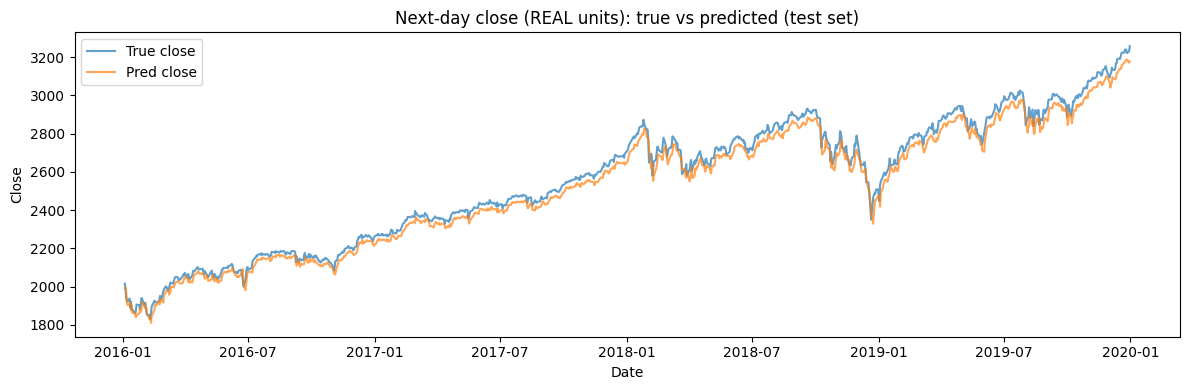

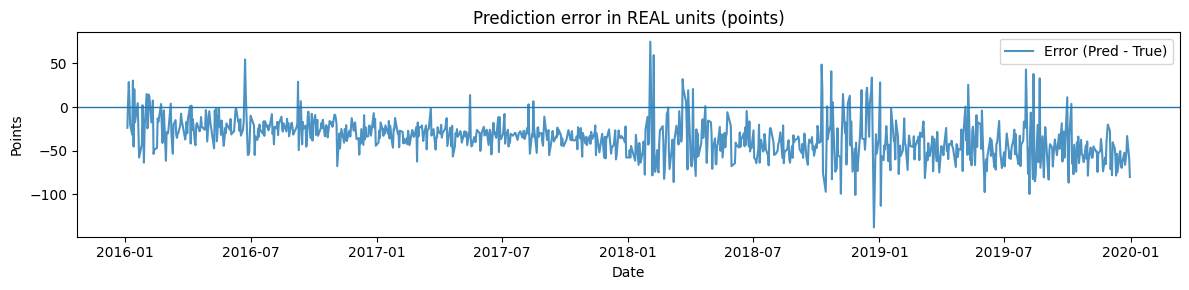


Metrics - SIMPLE returns:
{'MSE': np.float64(0.0002569544822179452), 'RMSE': np.float64(0.01602979981839902), 'MAE': np.float64(0.014610872789894844), 'R2': -2.9750499684232863}


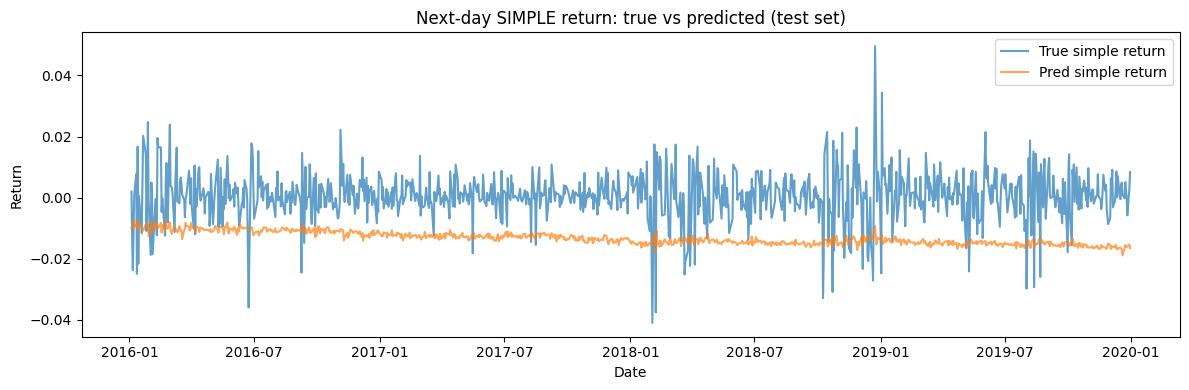

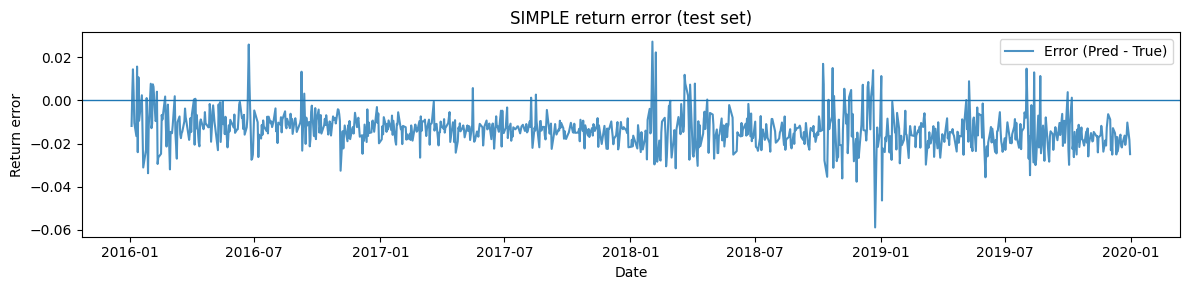


Metrics - LOG returns:
{'MSE': np.float64(0.0002589174434537571), 'RMSE': np.float64(0.01609091182791569), 'MAE': np.float64(0.01468571742565108), 'R2': -2.9902160569036216}


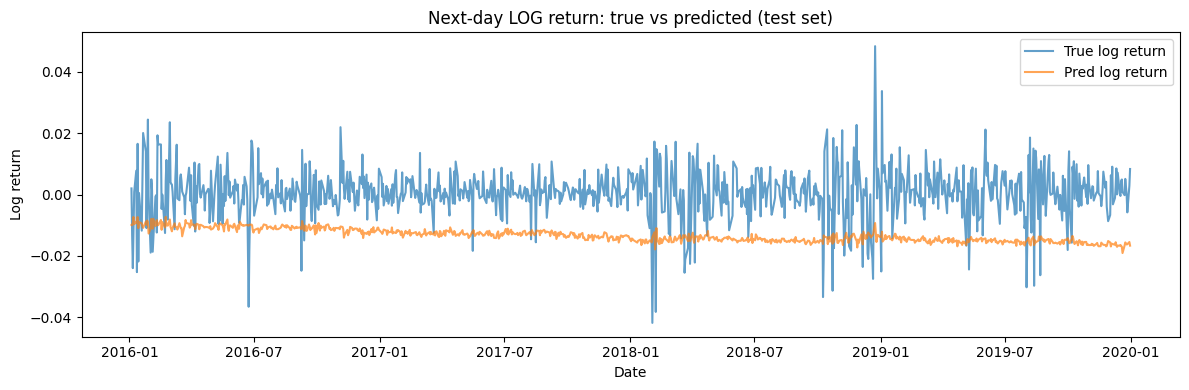

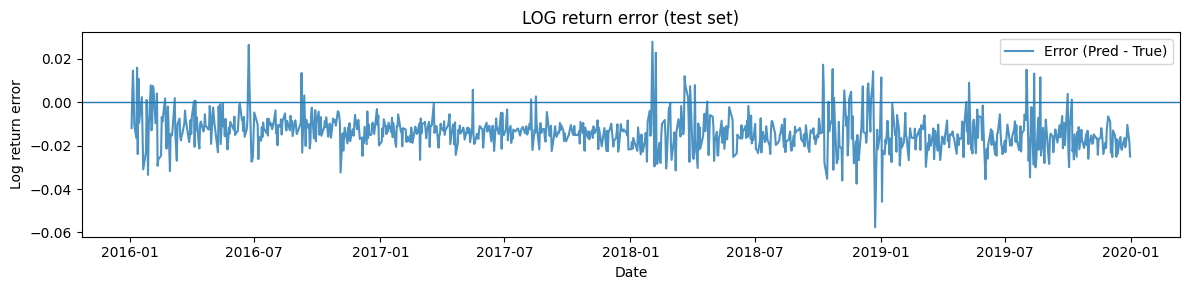

In [30]:
run_best_paper_model_price_target(cfg, headline_embs=headline_embs)